In [100]:
#Compute energy generated based on turbine type and wind speed data
import csv
import numpy as np
import xarray as xr
from WindCFGeoPlot import GeoPlot
#run on GeoPlots

#Turbines available:
#Haliade150_6MW
#ATB_8MW_2020_Vestas
#ATB_12MW_2030
#ATB_15MW_2030
#ATB_18MW_2030

WindTurbine="ATB_18MW_2030" #Name of the wind turbine file

WindSpeedHeightsAvailable={"100":"windspeed_100m.npz",
                         "140":"windspeed_140m.npz",
                         "160":"windspeed_160m.npz"}

#"160":"windspeed_160m.npz"

#windspeed_160m.npz: seems to not be correct
GridScale=2#km


#Read wind turbine data
def Condition_on_TurbineData(WindTurbine):
    
    PowerCurve=[]
    PowerCurve.append(['0','0'])
    
    File_Wind=open(WindTurbine+'.txt', "r")
    File_Wind_csv=csv.reader(File_Wind,delimiter=';')
    
    for EachLine in File_Wind_csv:
        
        if File_Wind_csv.line_num==1:
            HubHeight=float(EachLine[1])
            
        if File_Wind_csv.line_num==2:
            Total_Efficiency=1-float(EachLine[1])
            
        if File_Wind_csv.line_num==3:
            RotorDiameter=float(EachLine[1])

        if File_Wind_csv.line_num==4:
            RatedPower=float(EachLine[1])
            
        if File_Wind_csv.line_num>=6:
            PowerCurve.append(EachLine[:])

    PowerCurve=np.asarray(PowerCurve, dtype='float32')
    
    File_Wind.close()
    
    return HubHeight, Total_Efficiency, RotorDiameter, PowerCurve, RatedPower
HubHeight, Total_Efficiency, RotorDiameter, PowerCurve, RatedPower=Condition_on_TurbineData(WindTurbine)

# Full wind sites without any filtering

In [101]:
#Convert wind speed to energy in pu
def WindToEnergy(WindTurbine, Save=True):
       
    HubHeight, Total_Efficiency, RotorDiameter, PowerCurve, RatedPower=Condition_on_TurbineData(WindTurbine)

    HeightsAvaialble=np.asarray(list(WindSpeedHeightsAvailable.keys()),dtype="int")

    #Get files we are going to use to perfrom conversion of wind speed to the hub height
    #ul/uh=(zl/zh)^alpha

    IdxUpperWindFile=np.argmin(np.abs(HeightsAvaialble-HubHeight)) #Get the closest height available
    if HeightsAvaialble[IdxUpperWindFile]-HubHeight<0:
        IdxUpperWindFile=min(IdxUpperWindFile+1,len(HeightsAvaialble)-1)

    IdxUpperWindFile=max(IdxUpperWindFile,1)
    IdxLowerWindFile=IdxUpperWindFile-1

    LWindFileName=WindSpeedHeightsAvailable[list(WindSpeedHeightsAvailable.keys())[IdxLowerWindFile]]
    HWindFileName=WindSpeedHeightsAvailable[list(WindSpeedHeightsAvailable.keys())[IdxUpperWindFile]]

    LWindData=np.load(LWindFileName)["windspeed"]
    HWindData=np.load(HWindFileName)["windspeed"]
    
    LatLong=np.load(LWindFileName)["LatLong"]


    # HubHeight
    alpha=np.log(HWindData/LWindData)/np.log(HeightsAvaialble[IdxUpperWindFile]/HeightsAvaialble[IdxLowerWindFile])
    
    if HeightsAvaialble[IdxUpperWindFile]<=HubHeight:
        h_ref=HeightsAvaialble[IdxUpperWindFile]
        WS_Ref=HWindData
    else:
        h_ref=HeightsAvaialble[IdxLowerWindFile]
        WS_Ref=LWindData
    
    WS_Hub=WS_Ref*(HubHeight/h_ref)**alpha #Wind speed at the hub height

    WindEnergy_pu=np.interp(WS_Hub,PowerCurve[:,0],PowerCurve[:,1])

    ReadMe='\
    EnergyPu: pu wind energy \n\
    1) The data is in hourly discretization starting at 1/1/2007 and going up to\
     12/31/2013 23:00'
    
    if Save:
        np.savez("WindEnergyNotFiltered_"+WindTurbine+'.npz',ReadMe=ReadMe,WindEnergy=WindEnergy_pu, RatedPower=RatedPower, LatLong=LatLong)
        

    return WindEnergy_pu, RatedPower, LatLong, WS_Hub

In [102]:
WindEnergy_pu, RatedPower, LatLong, WS_Hub=WindToEnergy(WindTurbine, Save=False)

#Filter out sites with zero wind (NREL data at land is not accurate for this case)
AvgWindWindEnergy_pu=np.mean(WindEnergy_pu,axis=0)
IdxIn=AvgWindWindEnergy_pu>0 #site with zero wind at land locations (NREL approximations Ignore them)
WindEnergy_pu=WindEnergy_pu[:,IdxIn]
LatLong=LatLong[IdxIn,:]
WS_Hub=WS_Hub[:,IdxIn]

#get depth and distance from shore for each site
#####----
#Distance between two lat long points
def DistanceToShore (CoastLine, LatLong1): #Compute distance to shore in km of a lat long point
   
    CoastLine=CoastLine*2*np.pi/360
    LatLong1=LatLong1*2*np.pi/360
    
    LatLong1=np.reshape(LatLong1,(1,2))
    dLat=LatLong1[:,0]-CoastLine[:,0]
    dLong=LatLong1[:,1]-CoastLine[:,1]
    
    a=np.power(np.sin(dLat/2),2)+np.cos(CoastLine[:,0])*np.cos(LatLong1[:,0])*np.power(np.sin(dLong/2),2)
    c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
    d=6367*c
    
    Distance=np.min(d) #Minimum distance to shore km
    
    return Distance

#Get coastline data
CoastLine=[]

File_CoastLine=open('./GEO_data/NC_Coastline.csv', "r")
File_CoastLine_csv=csv.reader(File_CoastLine,delimiter=',')

for EachLine in File_CoastLine_csv:

    if File_CoastLine_csv.line_num > 1:
        CoastLine.append([float(EachLine[1]), float(EachLine[0])] ) #LatLong

CoastLine=np.array(CoastLine)


Depth_NETCDF = xr.open_dataset("./Depths.nc")#File with bathymetry data

def GetDepth(Lat,Long):
    
    I_lat=np.argmin(np.square(Depth_NETCDF.lat.data-Lat))
    I_lon=np.argmin(np.square(Depth_NETCDF.lon.data-Long))
    
    depth=Depth_NETCDF.elevation.data[I_lat,I_lon]  
    
    return depth

Depth=[]
Distance2Shore=[]

for i in range(LatLong.shape[0]):
    Lat=LatLong[i,0]
    Long=LatLong[i,1]
    
    Depth.append(GetDepth(Lat,Long))
    Distance2Shore.append(DistanceToShore (CoastLine, np.array([Lat,Long])))
    
    
Depth=np.abs(np.array(Depth)) #[m]
Distance2Shore=np.array(Distance2Shore) #[km]


C:\Users\Remote\AppData\Local\Temp\ipykernel_22868\3080739944.py:28: RuntimeWarning: divide by zero encountered in log
  alpha=np.log(HWindData/LWindData)/np.log(HeightsAvaialble[IdxUpperWindFile]/HeightsAvaialble[IdxLowerWindFile])


In [103]:
#Filter for a minimum depth of 1m and a minimum distance to shore of 5km

IdxIn= (Depth>1) & (Depth<=200) & (Distance2Shore>1) & (np.mean(WindEnergy_pu,axis=0)>=np.percentile(np.mean(WindEnergy_pu,axis=0),8))
#IdxIn= (np.mean(WindEnergy_pu,axis=0)>=np.percentile(np.mean(WindEnergy_pu,axis=0),10))
LatLong=LatLong[IdxIn,:]
WindEnergy_pu=WindEnergy_pu[:,IdxIn]
WS_Hub=WS_Hub[:,IdxIn]
Depth=Depth[IdxIn]
Distance2Shore=Distance2Shore[IdxIn]


Mean CF:  0.5010892995484663
Max CF:  0.5363004452027117
Min CF:  0.44235373653020443
90th percentile CF:  0.5296242501100408


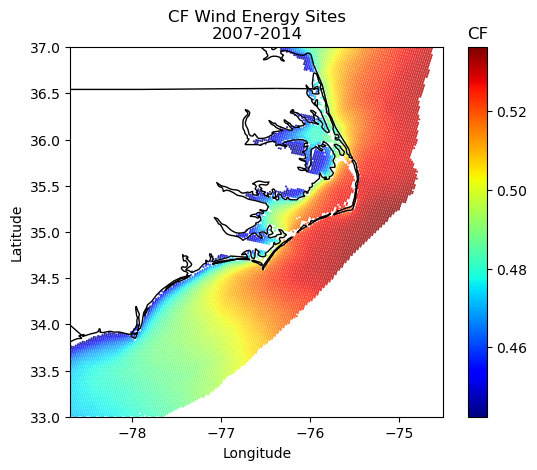

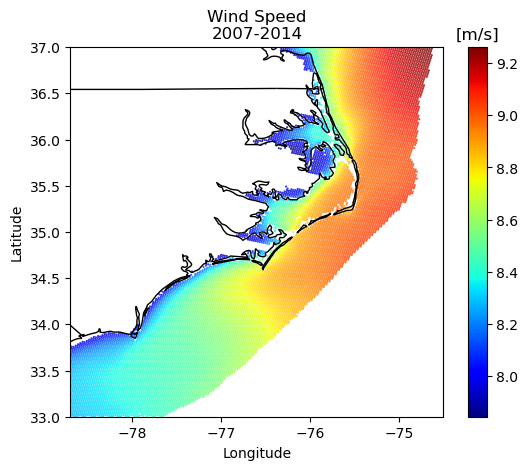

In [104]:
LatLong_WSData=LatLong
AvgWindWindEnergy_pu=np.mean(WindEnergy_pu,axis=0)
AvgWindSpeed=np.mean(WS_Hub,axis=0)

GeoPlot(AvgWindWindEnergy_pu, LatLong, WindTurbine+"_CF_", CF=True, WS=False)
GeoPlot(AvgWindSpeed, LatLong, WindTurbine+"_WS_", CF=False, WS=True)

#Max Min and 90th percentile
print("Mean CF: ", np.mean(AvgWindWindEnergy_pu))
print("Max CF: ", np.max(AvgWindWindEnergy_pu))
print("Min CF: ", np.min(AvgWindWindEnergy_pu))
print("90th percentile CF: ", np.percentile(AvgWindWindEnergy_pu,90))

In [105]:
#Save NREL portfolios
ReadMe='\
EnergyPu: pu wind energy -1 unit per site\n\
1) The data is in hourly discretization starting at 1/1/2007 and going up to\
    12/31/2013 23:00'
     
np.savez("WindEnergy_Average"+str(HubHeight)+"m_"+WindTurbine+'.npz',ReadMe=ReadMe, WindEnergy=AvgWindWindEnergy_pu, RatedPower=RatedPower, LatLong=LatLong_WSData,Depth=Depth, DistanceToShore=Distance2Shore)


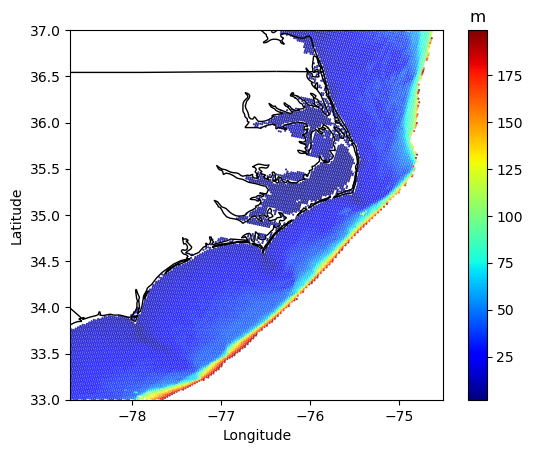

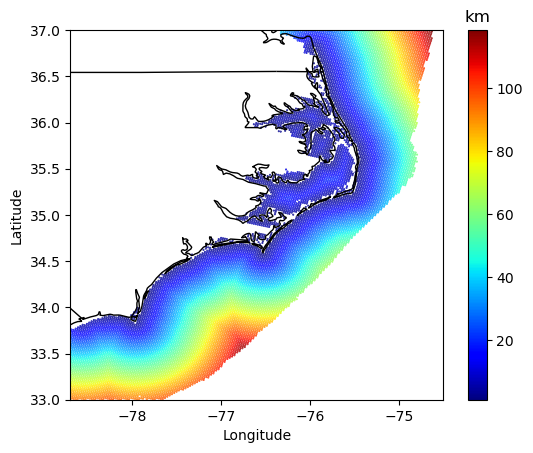

In [106]:
GeoPlot(Depth, LatLong, "Depth", NameCB="m")
GeoPlot(Distance2Shore, LatLong, "KmShore", NameCB="km")

# Filter using NREL wind Sites

Text(35.347222222222214, 0.5, 'Latitude')

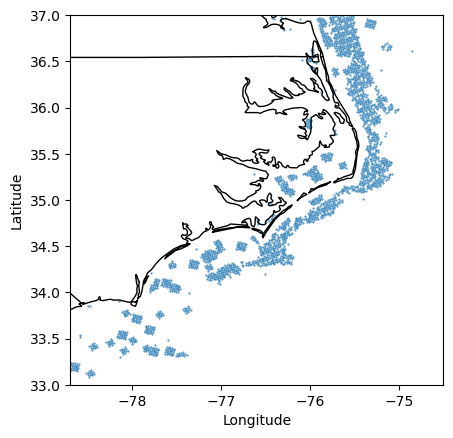

In [107]:
#It seems to not make much difference to filter based on NREL site, so we will not do it
import pandas as pd
import numpy as np
import geoplot as gplt
import geopandas as gpd
import matplotlib.colors as clrs
import matplotlib.pyplot as plt

#return depth and distance from shore
#read NREL EXCEL
NRELLimitSites=pd.read_csv("wtk_site_metadata.csv")
#NRELLimitSites=pd.read_csv("offshore-wind-open-access-siting-regime-atb-mid-turbine-fy21.csv")
NREL_Lat=NRELLimitSites["latitude"].values
NREL_Long=NRELLimitSites["longitude"].values
fraction_of_usable_area=NRELLimitSites["fraction_of_usable_area"].values
power_curve= NRELLimitSites["power_curve"].values
# NREL_Depth=NRELLimitSites["bathymetry_meters"].values #meters
# NREL_DistCoast=NRELLimitSites["distance_to_coast_km"].values #km

MaxLat=np.max(LatLong_WSData[:,0])
MinLat=np.min(LatLong_WSData[:,0])
MaxLong=np.max(LatLong_WSData[:,1])
MinLong=np.min(LatLong_WSData[:,1])

IdxNRELFilter=(NREL_Lat<=MaxLat) & (NREL_Lat>=MinLat) & (NREL_Long<=MaxLong) & (NREL_Long>=MinLong)\
    & (fraction_of_usable_area==1) &(power_curve=="offshore")

#& (NRELLimitSites["capacity_mw"]>20)
NREL_Lat=NREL_Lat[IdxNRELFilter]
NREL_Long=NREL_Long[IdxNRELFilter]
# NREL_Depth=NREL_Depth[IdxNRELFilter]
# NREL_DistCoast=NREL_DistCoast[IdxNRELFilter]
NREL_LatLong=np.stack((NREL_Lat, NREL_Long),axis=1)

#plot
ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"

min_longitude=-78.7
max_longitude=-74.5

min_latitude=33.0
max_latitude=37.0

xlim =[min_longitude,max_longitude]
ylim=[min_latitude, max_latitude]

df = gpd.read_file(ShapeFileCoast)
df1 = gpd.read_file(ShapeFileStates)

fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)


plt.scatter(NREL_Long,NREL_Lat, s=0.2)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [108]:
def MinDistanceSetPoints (SetPoints1, SetPoints2): #Compute distance to shore in km of a lat long point
    SetPoints1=SetPoints1*2*np.pi/360
    SetPoints2=SetPoints2*2*np.pi/360

    DMin=[]
    IdxMin=[]

    for i in range(SetPoints2.shape[0]):
        LatLong1=SetPoints2[i,:]
        LatLong1=np.reshape(LatLong1,(1,2))
        dLat=LatLong1[:,0]-SetPoints1[:,0]
        dLong=LatLong1[:,1]-SetPoints1[:,1]

        a=np.power(np.sin(dLat/2),2)+np.cos(SetPoints1[:,0])*np.cos(LatLong1[:,0])*np.power(np.sin(dLong/2),2)
        c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
        d=6367*c

        Distance=np.min(d) #Minimum distance km
        DMin.append(Distance)
        Idx=np.argmin(d)
        IdxMin.append(Idx)
        
    IdxMin=np.array(IdxMin)
    DMin=np.array(DMin)
    
    #Index from SetPoints1 that is closest to SetPoints2 element by element
    return IdxMin, DMin
IdxMin, DMin=MinDistanceSetPoints(LatLong_WSData, NREL_LatLong)
#exclude sites that are futher than 4km from wtk sites
IdxMin=IdxMin[DMin<=4]

In [109]:
#Sites filtered by NREL
LatLong_WSData_F_NREL=LatLong_WSData[IdxMin,:]
WindEnergy_pu_F_NREL=WindEnergy_pu[:,IdxMin]
WS_Hub_F_NREL=WS_Hub[:,IdxMin]
Depth_F_NREL=Depth[IdxMin]
Distance2Shore_F_NREL=Distance2Shore[IdxMin]


Mean CF:  0.5094204593520355
Max CF:  0.5349498464915151
Min CF:  0.4429532620745255
90th percentile CF:  0.529685056979417


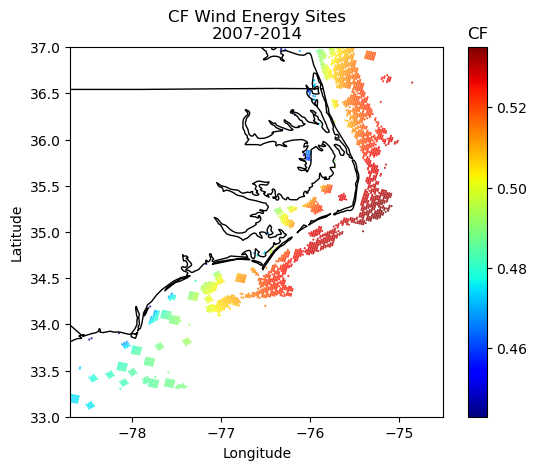

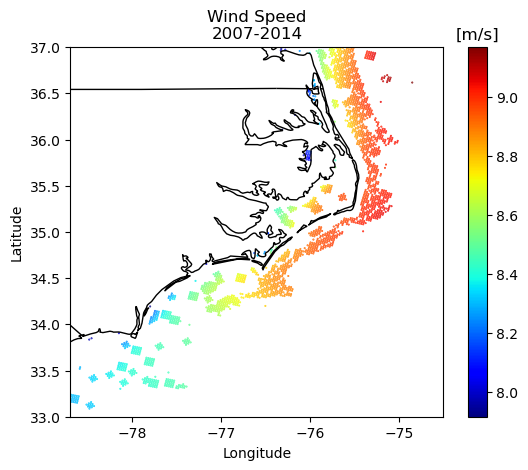

In [110]:


GeoPlot(np.mean(WindEnergy_pu_F_NREL,axis=0), LatLong_WSData_F_NREL, WindTurbine+"_CF_NREL_", CF=True, WS=False)
GeoPlot(np.mean(WS_Hub_F_NREL,axis=0), LatLong_WSData_F_NREL, WindTurbine+"_WS_NREL_", CF=False, WS=True)

#Max Min and 90th percentile
print("Mean CF: ", np.mean(np.mean(WindEnergy_pu_F_NREL,axis=0)))
print("Max CF: ", np.max(np.mean(WindEnergy_pu_F_NREL,axis=0)))
print("Min CF: ", np.min(np.mean(WindEnergy_pu_F_NREL,axis=0)))
print("90th percentile CF: ", np.percentile(np.mean(WindEnergy_pu_F_NREL,axis=0),90))

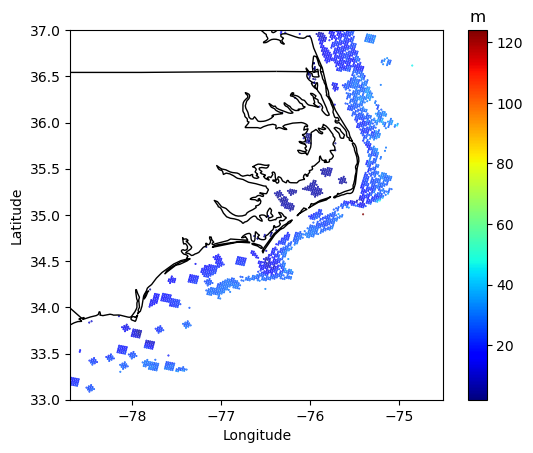

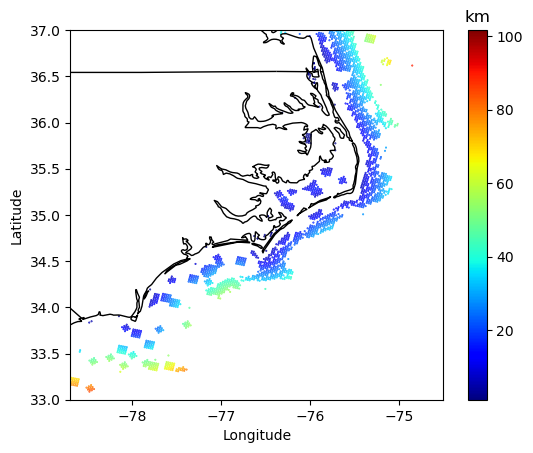

In [111]:
GeoPlot(Depth_F_NREL, LatLong_WSData_F_NREL, "Depth_NREL", NameCB="m")
GeoPlot(Distance2Shore_F_NREL, LatLong_WSData_F_NREL, "KmShore_NREL", NameCB="km")

In [112]:
#Save NREL portfolios
ReadMe='\
EnergyPu: pu wind energy -1 unit per site\n\
1) The data is in hourly discretization starting at 1/1/2007 and going up to\
    12/31/2013 23:00'
     
np.savez("WindEnergyNREL_"+str(HubHeight)+"m_"+WindTurbine+'.npz',ReadMe=ReadMe, WindEnergy=WindEnergy_pu_F_NREL, RatedPower=RatedPower, LatLong=LatLong_WSData_F_NREL,Depth=Depth_F_NREL, DistanceToShore=Distance2Shore_F_NREL)
